In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Poisson vs. Gaussian

In [3]:
from scipy.stats import norm, poisson

In [4]:
mu = 1000
rv_poisson = poisson(mu)

In [5]:
print(rv_poisson.stats(moments='mvsk'))

(array(1000.), array(1000.), array(0.03162278), array(0.001))


In [6]:
rv_gauss = norm(loc=mu, scale=np.sqrt(mu))
print(rv_gauss.stats(moments='mvsk'))

(array(1000.), array(1000.), array(0.), array(0.))


### Plot them to compare

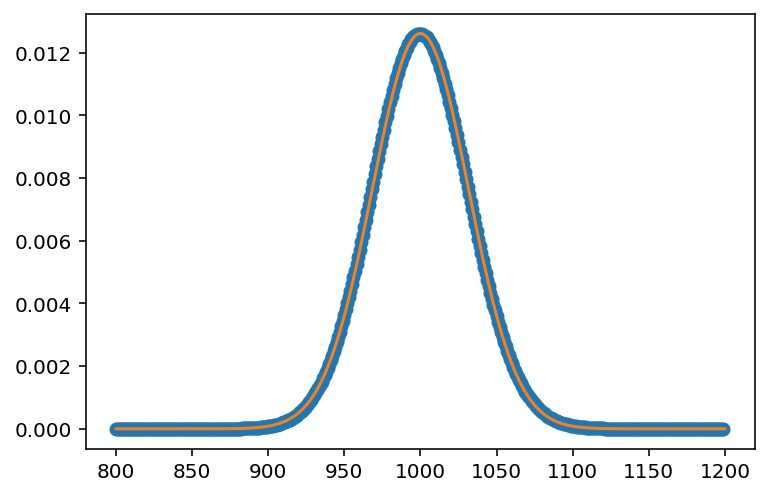

In [7]:
x = range(800, 1200)
plt.plot(x, rv_poisson.pmf(x), 'o')

x_to_plot = np.linspace(800, 1200, 10000)
plt.plot(x_to_plot, rv_gauss.pdf(x_to_plot))

---

# 2-Parameter Bayesian Estimate

## The sampler

Let's sample a 2D Gaussian:

$$ PDF_G(x, y) = \frac{\exp(-\frac{1}{2} (x-\mu)^T \Sigma^{-1} (x-\mu))}{\sqrt{(2 \pi)^2 det(\Sigma)}}$$

In [8]:
from scipy import linalg

In [9]:
mu = np.array([10, 3])
rho = 0.8
sigma_x = 2
sigma_y = 1
Sigma = [[             sigma_x**2, rho * sigma_x * sigma_y],
         [rho * sigma_x * sigma_y,             sigma_y**2]]

def gauss_2D(x, mu, rho, sigma_x, sigma_y):
    output = np.exp(-0.5 * (x-mu) @ linalg.inv(Sigma) @ (x-mu)) / np.sqrt((2 * np.pi)**2 * linalg.det(Sigma))
    return output

In [10]:
def log_prob(x, mu, rho, sigma_x, sigma_y):
    return np.log(gauss_2D(x, mu, rho, sigma_x, sigma_y))

In [11]:
import emcee

Setup the sampler

In [12]:
ndim = 2
nwalkers = 16

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[mu, rho, sigma_x, sigma_y])

Starting positions

In [13]:
p0 = np.array([10, 3]) + np.random.normal(loc=0, scale=1, size=(nwalkers, ndim))
print(p0)

[[ 9.72959987  1.57802904]
 [ 8.13136319  6.2489588 ]
 [ 9.9075092   2.66610803]
 [ 9.86988399  1.60814595]
 [10.61877002  2.75105229]
 [ 9.78837159  2.69080586]
 [10.48487043  2.90957899]
 [ 9.91032533  2.63895018]
 [11.00082875  3.38301504]
 [10.37482329  5.07756753]
 [11.16405113  3.5067262 ]
 [ 8.1247786   2.55736253]
 [10.19247085  3.56526765]
 [10.49191132  3.4890852 ]
 [10.93687594  3.51127772]
 [ 9.1814688   4.4475358 ]]


Run MCMC

In [14]:
sampler.run_mcmc(p0, 3000, rstate0=45);

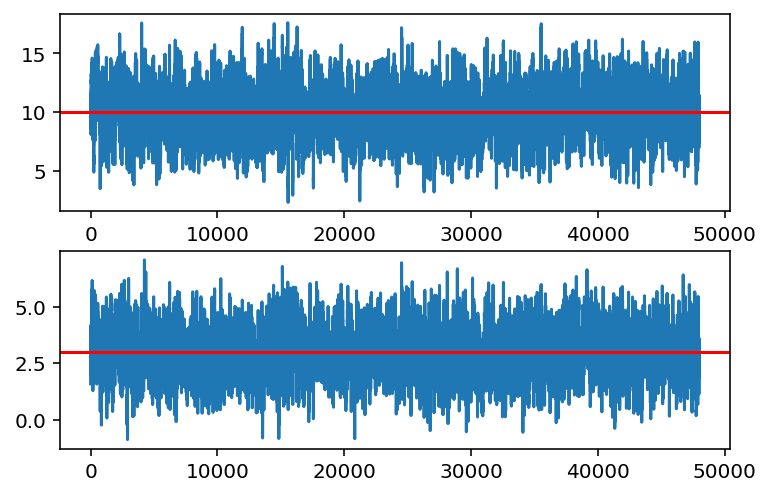

In [15]:
plt.subplot(211)
plt.plot(sampler.flatchain[:,0])
plt.axhline(10, color='r')

plt.subplot(212)
plt.plot(sampler.flatchain[:,1])
plt.axhline(3, color='r')

In [16]:
import corner

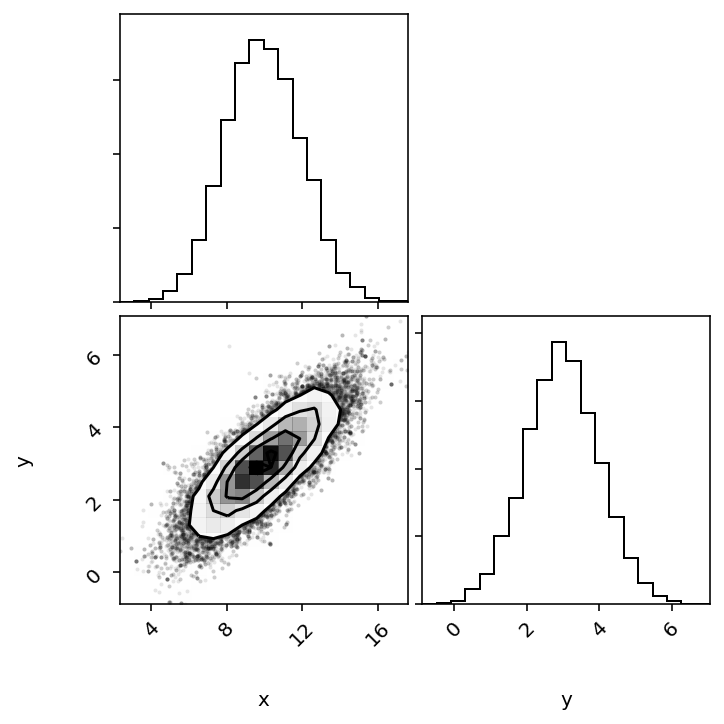

In [17]:
fig = corner.corner(sampler.flatchain, labels=['x', 'y'])

---

## Parameter Estimates

### Defining the sample to play with

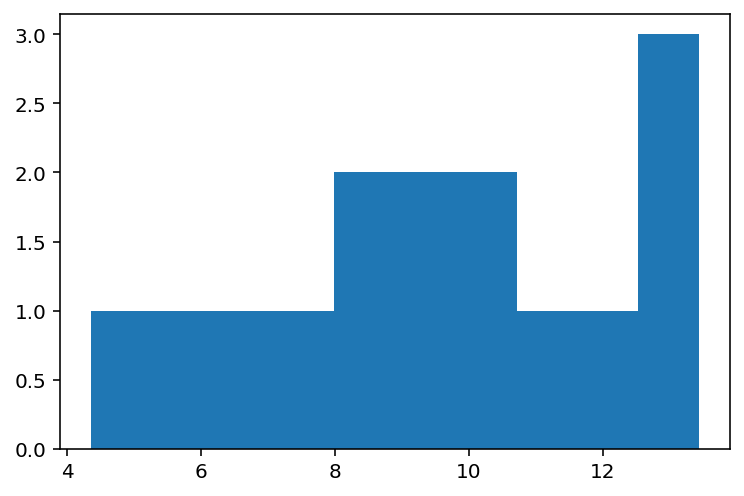

In [18]:
mu = 10
sigma = 3
N_sample = 15
np.random.seed(5456345)
sample = norm.rvs(loc=mu, scale=sigma, size=N_sample)

plt.hist(sample);

In [19]:
np.mean(sample)

9.621152027735397

In [20]:
np.std(sample)

2.5467968727331485

## Doing the Bayesian analysis

Need to start by defining the function to evaluate the posterior.

In [21]:
def log_likelihood(mu, sigma, x):
    return - 0.5 * np.sum((mu - x)**2 / sigma**2 + np.log(sigma**2))

# def log_prior(mu, sigma):  # This one is a flat prior
#     if -100.0 < mu < 100 and -50<sigma<50:
#         return 0.0
#     return -np.inf

def log_prior(mu, sigma):  # This one is a gaussian prior
    return - (mu-10)**2/2/5**2 - (sigma-3)**2/2/1**2

def lnprob(params, x):
    mu, sigma = params
    lp = log_prior(mu, sigma)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(mu, sigma, x)

Setup de Sampler

In [22]:
import emcee

ndim = 2
nwalkers = 16

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[sample])

Setup the starting points for the set of walkers

In [23]:
mu_p0 = norm.rvs(loc=0, scale=10, size=(nwalkers))
sigma_p0 = poisson.rvs(30, size=nwalkers)

p0 = np.stack((mu_p0, sigma_p0), axis=1)

Text(0, 0.5, '$\\sigma$')

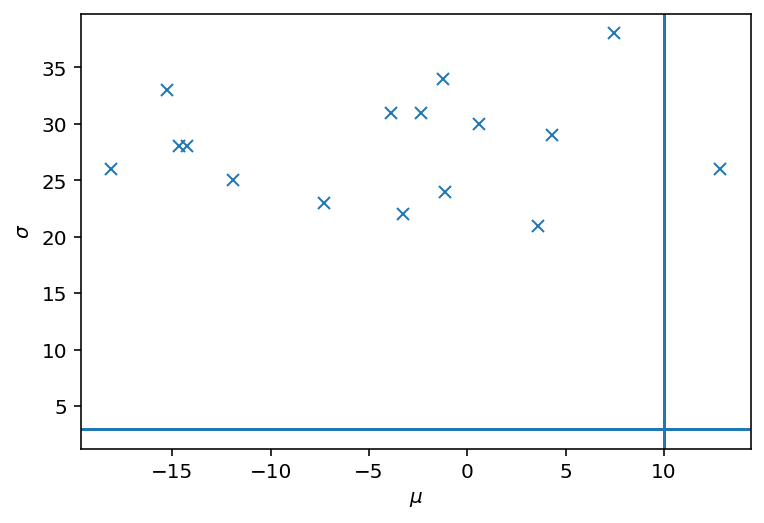

In [24]:
plt.plot(mu_p0, sigma_p0, 'x')

plt.axvline(mu)
plt.axhline(sigma)

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

Run the sampler

In [25]:
sampler.run_mcmc(p0, 5000, rstate0=43);

Explore the chains

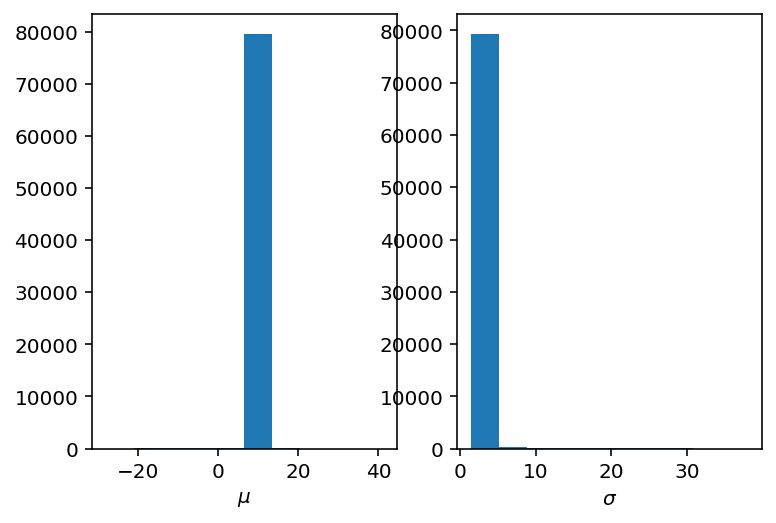

In [26]:
plt.subplot(121)
plt.hist(sampler.flatchain[:,0])
plt.xlabel(r'$\mu$')

plt.subplot(122)
plt.hist(sampler.flatchain[:,1])
plt.xlabel(r'$\sigma$');

Text(0, 0.5, '$\\mu$')

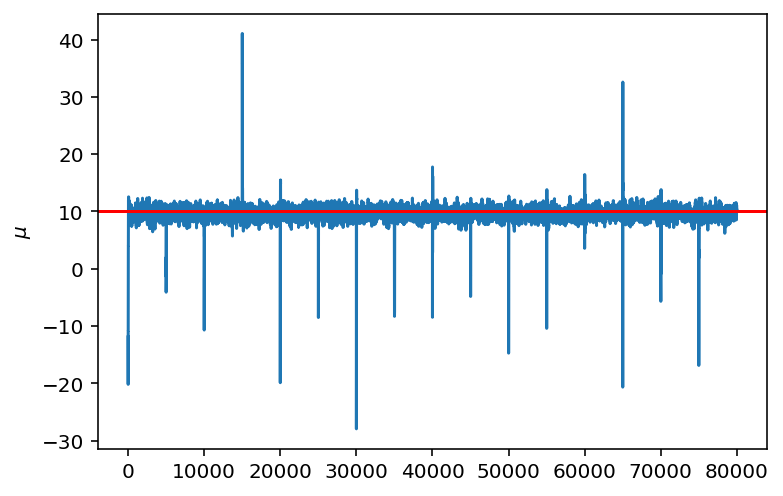

In [27]:
plt.plot(sampler.flatchain[:,0])
plt.axhline(10, color='r')
plt.ylabel(r'$\mu$')

Text(0, 0.5, '$\\sigma$')

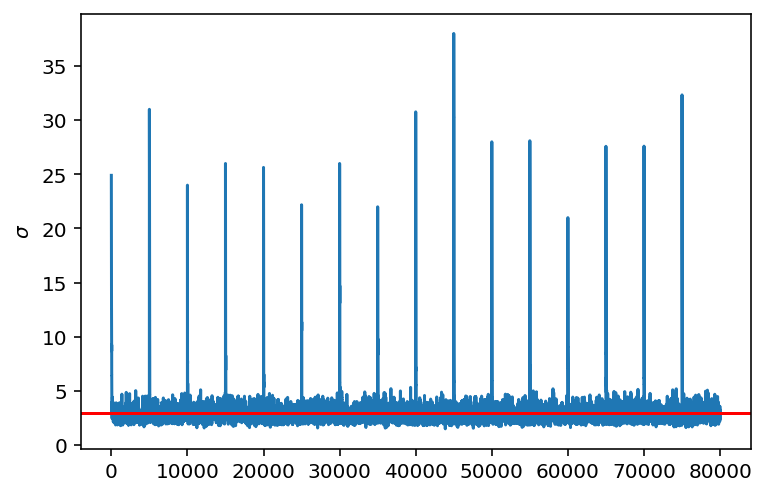

In [28]:
plt.plot(np.fabs(sampler.flatchain[:,1]))
plt.axhline(3, color='r')
plt.ylabel(r'$\sigma$')

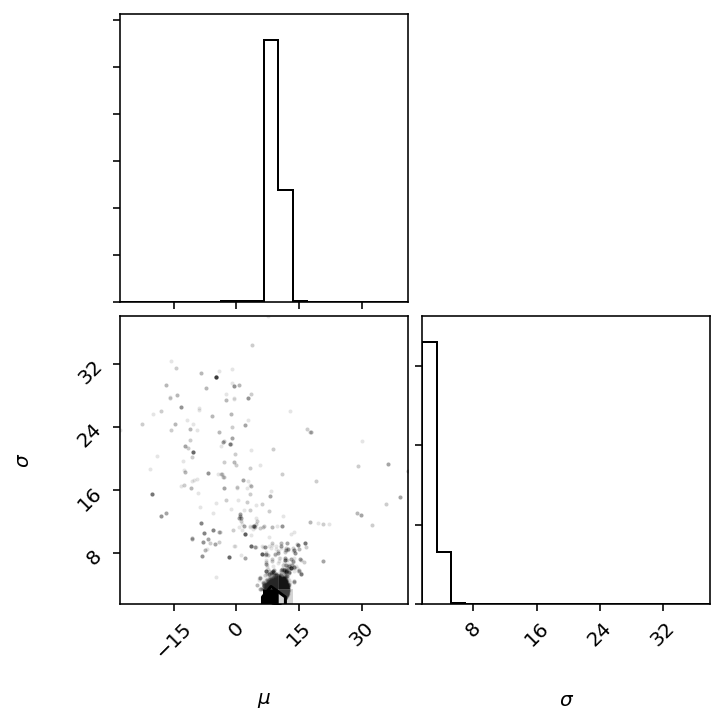

In [29]:
fig = corner.corner(sampler.flatchain, labels=[r'$\mu$', r'$\sigma$'])

It's a fairly common problem that it looks this bad, too many outliers. The parameter `range` helps with the visualization, check the documentation [here](https://corner.readthedocs.io/en/latest/).

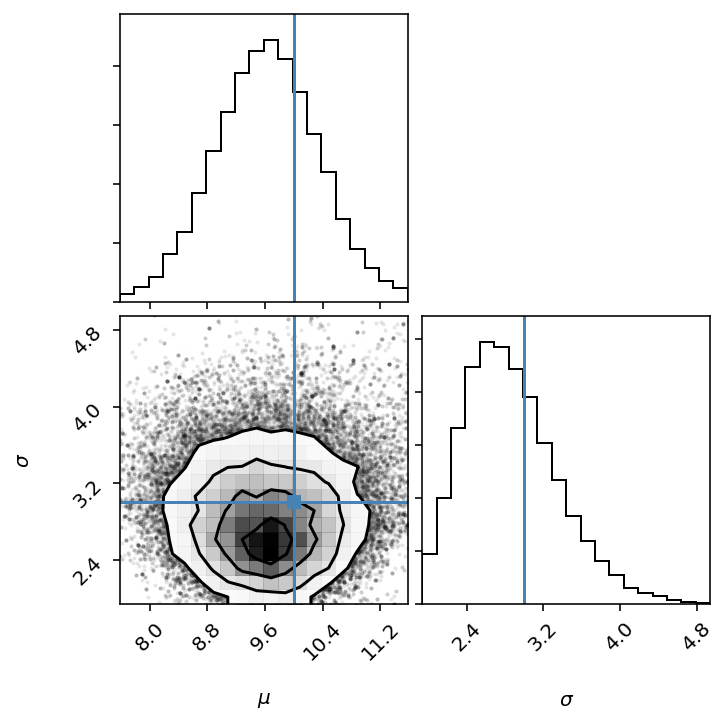

In [30]:
fig = corner.corner(sampler.flatchain, labels=[r'$\mu$', r'$\sigma$'], range=(0.98, 0.98), truths=[10, 3])